In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from collections import Counter
import tensorflow as tf
import keras

In [2]:
f = h5py.File('mouse1sample1.hdf5','r')


In [3]:
annotated_cells = []
annotations = []
for cell_id in f['cells']:
    cell = f['cells'][cell_id]
    ann = dict(cell.attrs)['annotation']
    if ann != 'unannotated':
        annotated_cells.append(cell_id)
        annotations.append(ann)
annotations_count = Counter(annotations)

Number of Annotated Samples: 18453
Num of Cell Types: 93
Max Number of Samples per Cell Type: 2136
Min Number of Samples per Cell Type: 1
Average Number of Samples per Cell Type: 198.41935483870967


<BarContainer object of 93 artists>

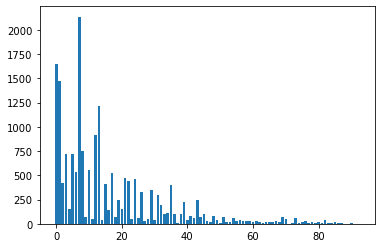

In [4]:
print("Number of Annotated Samples:", len(annotated_cells))
print("Num of Cell Types:", len(annotations_count))
print("Max Number of Samples per Cell Type:", max(annotations_count.values()))
print("Min Number of Samples per Cell Type:", min(annotations_count.values()))
print("Average Number of Samples per Cell Type:", sum(annotations_count.values())/93)

#graph of num of samples across cell-types 
plt.bar(np.arange(0,93), annotations_count.values())

In [5]:
# creating one-hot coded vectors for cell-type (labels for multi)
annotation_indices = {k: v for v, k in enumerate(list(annotations_count.keys()))}
labels = np.zeros((len(annotated_cells), len(annotation_indices)))
for index in range(0, len(annotated_cells)):
    cell = f['cells'][annotated_cells[index]]
    ann = dict(cell.attrs)['annotation']
    arr_index = annotation_indices[ann]
    labels[index][arr_index] = 1

In [6]:
# data = np.zeros(shape=(len(annotated_cells), 288, 432)).astype('uint8')

# fig = plt.figure()
# plt.gray()
# idx = 0
# for cell_id in annotated_cells:
#     cell = f['cells'][cell_id]
#     keys = list(cell['boundaries'].keys())
#     midpoint = keys[int(len(keys)/2)]
#     boundary = cell['boundaries'][midpoint]
#     xs = boundary[:,0]
#     ys = boundary[:,1]
#     plt.plot(xs,ys)
#     plt.axis('equal')
#     plt.xticks([])
#     plt.yticks([])
#     fig.canvas.draw()
#     fig_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
#     fig_array = fig_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     data[idx] = fig_array[:,:,0].astype('uint8')
#     idx += 1
#     plt.clf()
#     print(f"\r{idx}", end="")

# np.save('boundary_arrays', data)

In [7]:
data = np.load('boundary_arrays.npy')
data = np.repeat(data[..., np.newaxis], 3, -1)


In [8]:
from sklearn.model_selection import train_test_split
train, test, train_y, test_y = train_test_split(data, labels, test_size=0.3)

test, val, test_y, val_y = train_test_split(test, test_y, test_size=0.5)
print(train.shape, train_y.shape)
print(val.shape, val_y.shape)
print(test.shape, test_y.shape)

(12917, 288, 432, 3) (12917, 93)
(2768, 288, 432, 3) (2768, 93)
(2768, 288, 432, 3) (2768, 93)


In [25]:
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(288,432, 3), pooling=None, classes=93
)

base_model.trainable=False



In [26]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, train, y,
                 batch_size=16,
                 input_size=(288, 432, 3),
                 shuffle=True):
        
        self.train = train
        self.y = y
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(train)
    
    
    def on_epoch_end(self):
        pass
    
    def __getitem__(self, index):
        x_batch = self.train[index * self.batch_size:(index + 1) * self.batch_size]
        y_batch = self.y[index * self.batch_size:(index + 1) * self.batch_size]
        return x_batch, y_batch
    
    def __len__(self):
        return self.n // self.batch_size

In [27]:
train_gen = CustomDataGen(train, train_y)
val_gen = CustomDataGen(val, val_y)

In [28]:
inputs = keras.Input(shape=(288, 432, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(93)(x)
model = keras.Model(inputs, outputs)

In [ ]:
lr= tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=True)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# model.fit(train, train_y, batch_size=1, epochs=20, validation_data=(val, val_y))
history = model.fit(
    train_gen, 
    epochs=10,
    validation_data=val_gen
)

Epoch 1/10
807/807 [==============================] - ETA: 0s - loss: 8.1953 - accuracy: 0.0042

In [19]:
model.evaluate(test, test_y)

2021-11-05 22:37:35.007694: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1033150464 exceeds 10% of free system memory.
2021-11-05 22:37:36.278561: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1033150464 exceeds 10% of free system memory.


87/87 [==============================] - 49s 513ms/step - loss: 7.6353 - accuracy: 0.1113


[7.635293483734131, 0.1112716794013977]